In [40]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.metrics import jaccard_score
from collections import defaultdict

from jeopardy_funcs import get_topics, get_difficulty, prep_data, get_relevancies, compute_similarities, plot_Jaccard_matrix, mean_max_Jaccard

%config InlineBackend.figure_format = 'retina';

## Load in the Questions

In [2]:
df = pd.read_json('JEOPARDY_QUESTIONS1.json')
df = prep_data(df)
f"{df.shape[0] - df['question'].nunique()} questions are repeats."

'798 questions are repeats.'

In [3]:
f"There are {df['category'].nunique():,} unique categories in Jeopardy!"

'There are 27,995 unique categories in Jeopardy!'

Random question.

In [4]:
print(df.iloc[np.random.choice(range(df.shape[0]), 1)][['question','answer']].values)

[["'In a children's tale, this city of Germany is known for its band of animal musicians'"
  'Bremen']]


# 2: Difficulty of Questions Over Time
## a) Comparing topics between difficulty levels in Jeopardy! and Double Jeopardy! rounds
Since there will be too many topics to observe, we will look at the 5 most common topics per difficulty level. We need to first find the topics per difficulty level. Then, using the topic-matrix, we sort term relevancies to see the most important words in each topic. Finally, we find the top 5 most common topics, and look at the sorted term lists of those topics. We need to repeat this process for both the 'Jeopardy!' and 'Double Jeopardy!' rounds.
### 'Jeopardy!' Round

In [3]:
jeopardy_df = get_difficulty(df.loc[df['round'] == 'Jeopardy!', :])

In [12]:
j_results = get_relevancies(jeopardy_df, 25, 5)

col: difficulty, val: 1: Computing topics...
	1: Finding word relevancies...
	1: Finding top 25 most common topics...
col: difficulty, val: 2: Computing topics...
	2: Finding word relevancies...
	2: Finding top 25 most common topics...
col: difficulty, val: 3: Computing topics...
	3: Finding word relevancies...
	3: Finding top 25 most common topics...
col: difficulty, val: 4: Computing topics...
	4: Finding word relevancies...
	4: Finding top 25 most common topics...
col: difficulty, val: 5: Computing topics...
	5: Finding word relevancies...
	5: Finding top 25 most common topics...
col: difficulty, val: 6: Computing topics...
	6: Finding word relevancies...
	6: Finding top 25 most common topics...


### 'Double Jeopardy!' Round

In [6]:
dbl_df = get_difficulty(df.loc[df['round'] == 'Double Jeopardy!'])

In [13]:
dbl_results = get_relevancies(dbl_df, 25, 5)

col: difficulty, val: 1: Computing topics...
	1: Finding word relevancies...
	1: Finding top 25 most common topics...
col: difficulty, val: 2: Computing topics...
	2: Finding word relevancies...
	2: Finding top 25 most common topics...
col: difficulty, val: 3: Computing topics...
	3: Finding word relevancies...
	3: Finding top 25 most common topics...
col: difficulty, val: 4: Computing topics...
	4: Finding word relevancies...
	4: Finding top 25 most common topics...
col: difficulty, val: 5: Computing topics...
	5: Finding word relevancies...
	5: Finding top 25 most common topics...
col: difficulty, val: 6: Computing topics...
	6: Finding word relevancies...
	6: Finding top 25 most common topics...


## Comparison
We now want to find any similarities between the topics at different difficulty levels. At first, I thought we would only need to compare questions at the same difficulty level, but from some testing I found there were similarities between topics in different difficulty levels. In order to understand the total relatedness of the difficuty-topic groups, we will construct a similarity matrix, where cell $i, j$ represents the 'mean-max' Jaccard similarity index between Jeopardy! difficulty $i$ and Double Jeopardy! difficulty $j$. 'Mean-max' Jaccard score is an idea we created to compare all the sub groups in two sets. The idea is to find the maximum Jaccard similarity between each subset in set A and every other subset in set B. Then we take the average of all those scores to determine the total similarity between groups.

When computing the Jaccard similarity matrix, we realized that if we compared the full list of terms between topics, the Jaccard scores would all increase, because with more terms, there is a higher chance that more terms will be shared between topics. So, we set a parameter for the max number of terms to compare between topics. This gives us flexibility to see how the relationships change when increasing the maximum number of terms to compare. As a note, we take these terms in order of their relevancy to a topic, so we are essentially comparing the 'top' terms between topics. After some testing, since there are about 9,000 terms in each topic list, we chose 500 for our maximum number of terms to compare.

In [17]:
J = []
for difficulty in j_results.values():
    J.append(difficulty['top'])
    
D = []
for difficulty in dbl_results.values():
    D.append(difficulty['top'])

This Jaccard matrix gives us the min-max normalized mean-max Jaccard similarities between different difficulty levels in 'Jeopardy!' and 'Double Jeopardy!' rounds. This gives us a sense of how similar topic groups are relative to each other. Even for fairly similar topics, the Jaccard score isn't very high and when topics are very dissimilar, the Jaccard score is extremely small. So, we first take the $ln$ of the Jaccard scores, then min-max normalize the values. This gives us relative values, where a 1 corresponds to the 2 most similar difficulty levels. The nodes in the plot represent difficulty levels in different rounds of Jeopardy, and two nodes are connected if their normalized Jaccard similarity score is above a certain threshold. By default, we are using 0.8. The plot can be modified to plot _all_ connections and use the Jaccard score as an alpha value of the edges, but this results in a very cluttered picture, so we went the threshold route.

In [18]:
Jaccard_matrix = compute_similarities(J, D, max_elements=500)
Jaccard_matrix

,1,2,3,4,5,6
1,0.6226,0.6569,0.6629,0.6425,0.3211,0.3201
2,0.6497,0.6323,0.6497,0.6970,1.0000,0.6419
3,0.6128,0.8790,0.0553,0.6206,0.0464,0.5853
4,0.5844,0.2926,0.0281,0.3201,0.3101,0.9688
5,0.6126,0.9692,0.9734,0.6536,0.6385,0.3222
6,0.3112,0.5866,0.5861,0.8970,0.0000,0.6060


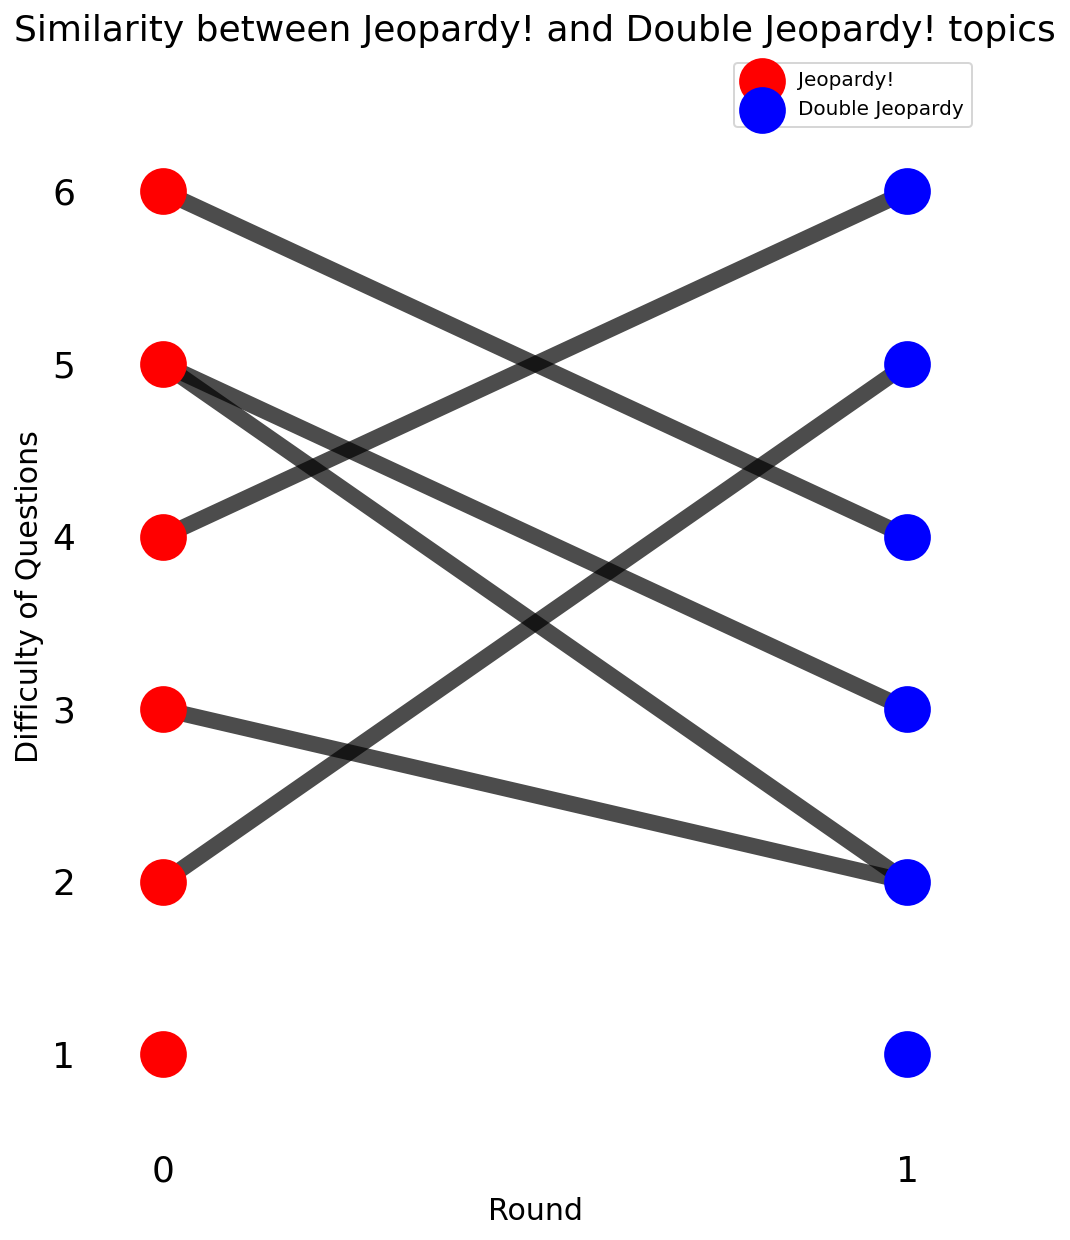

In [20]:
plot_Jaccard_matrix(Jaccard_matrix, threshold=0.8)

Based on various NMF runs and Jaccard matrix plots, we can make a few observations.
1) There isn't a clear link between topics at the difficulty level. In all of the NMF runs, there weren't consistently strong links between the same difficulty levels in 'Jeopardy!' and 'Double Jeopardy!'. A few times, we found strong links between the difficulty 1 and 6 questions, but again, it wasn't consistent.
2) The Jaccard similarity matrices vary a lot from run to run. We found that the similarity matrices would vary greatly across many runs. Due to the high level of aggregation involved, this variance makes sense, but it's hard to say exactly why the topics vary so much. One reason could be that we aren't handling 'Daily Double' questions specifically, so their non-static monetary values could be affecting performance of the models.
3) The strongest links appear to be between different difficulty groups. One consistent pattern we found was that difficult questions (4, 5, 6) in the 'Jeopardy!' round often had strong links to easy questions (1, 2, 3) in the 'Double Jeopardy!' round. This may be because the 'Double Jeopardy!' questions are harder, so it would make sense that the 'easy' questions in this round have similar topics to difficult questions in the 'Jeopardy!' round.

Though the results vary widely, I think the biggest takeaway from this part of our analysis is that topics are probably not tied to difficulty. I think that the high variability in connections means that any given topic can have both easy and difficult questions. As an extension, it would be interesting to compare different similarity metrics to Jaccard. 

## b) Comparing topics per difficulty over time
Now, we are going to take a look at Jaccarc similarities between difficulty groups over time. For this analysis, we are going to look just at similarities between the same difficulty levels over time. For instance, we will look at the mean-max Jaccard similarity between the topics of difficulty level 1 for 'Jeopardy!' and 'Double Jeopardy!' over time, the look at the same for difficulty level 2 and so on. In order to achieve this, we are going to plot the log of the Jaccard similarities over time. Since each year contains a varying level of data, the size of term lists per topic can vary a lot as well. Due to this, we need to change 'max_elements' over time. The easiest way to do this is find the smallest term list between two topic groups and then use a percentage of that number. For example, if we have two topic groups, each with 5 topics each, we have to look at 10 term lists. We find the smallest one, and then use a fraction of that size for our comparison. We chose to use 30% for our fraction of terms.

In [56]:
years = sorted(df.year.unique())

difficulty_similarities = defaultdict(list)

for year in years:
    year_df = df.loc[df.year == year, :]
    
    jeopardy_df = get_difficulty(year_df.loc[year_df['round'] == 'Jeopardy!', :])
    j_results = get_relevancies(jeopardy_df, 25, 5, verbose=False, min_df=0, max_df=1)
    
    dbl_df = get_difficulty(year_df.loc[year_df['round'] == 'Double Jeopardy!', :])
    dbl_results = get_relevancies(dbl_df, 25, 5, verbose=False, min_df=0, max_df=1)
    
    for difficulty in range(1,7):
        J_topics = j_results[difficulty]['top']
        D_topics = dbl_results[difficulty]['top']
        
        smallest_J = min(map(len, J_topics))
        smallest_D = min(map(len, D_topics))
        max_terms = int(min(smallest_J, smallest_D)*.3)  # get max terms
        
        similarity = mean_max_Jaccard(J_topics, D_topics, max_elements=max_terms)
        difficulty_similarities[difficulty].append(similarity)

/Users/zach.dougherty/anaconda3/envs/torch_env/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:111: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(res * 2)


Now, we are going to plot the similarities of difficulty levels over time and see if we can find some relationship. I decided to reverse the log transform, because we get a natural baseline of 0 to compare.

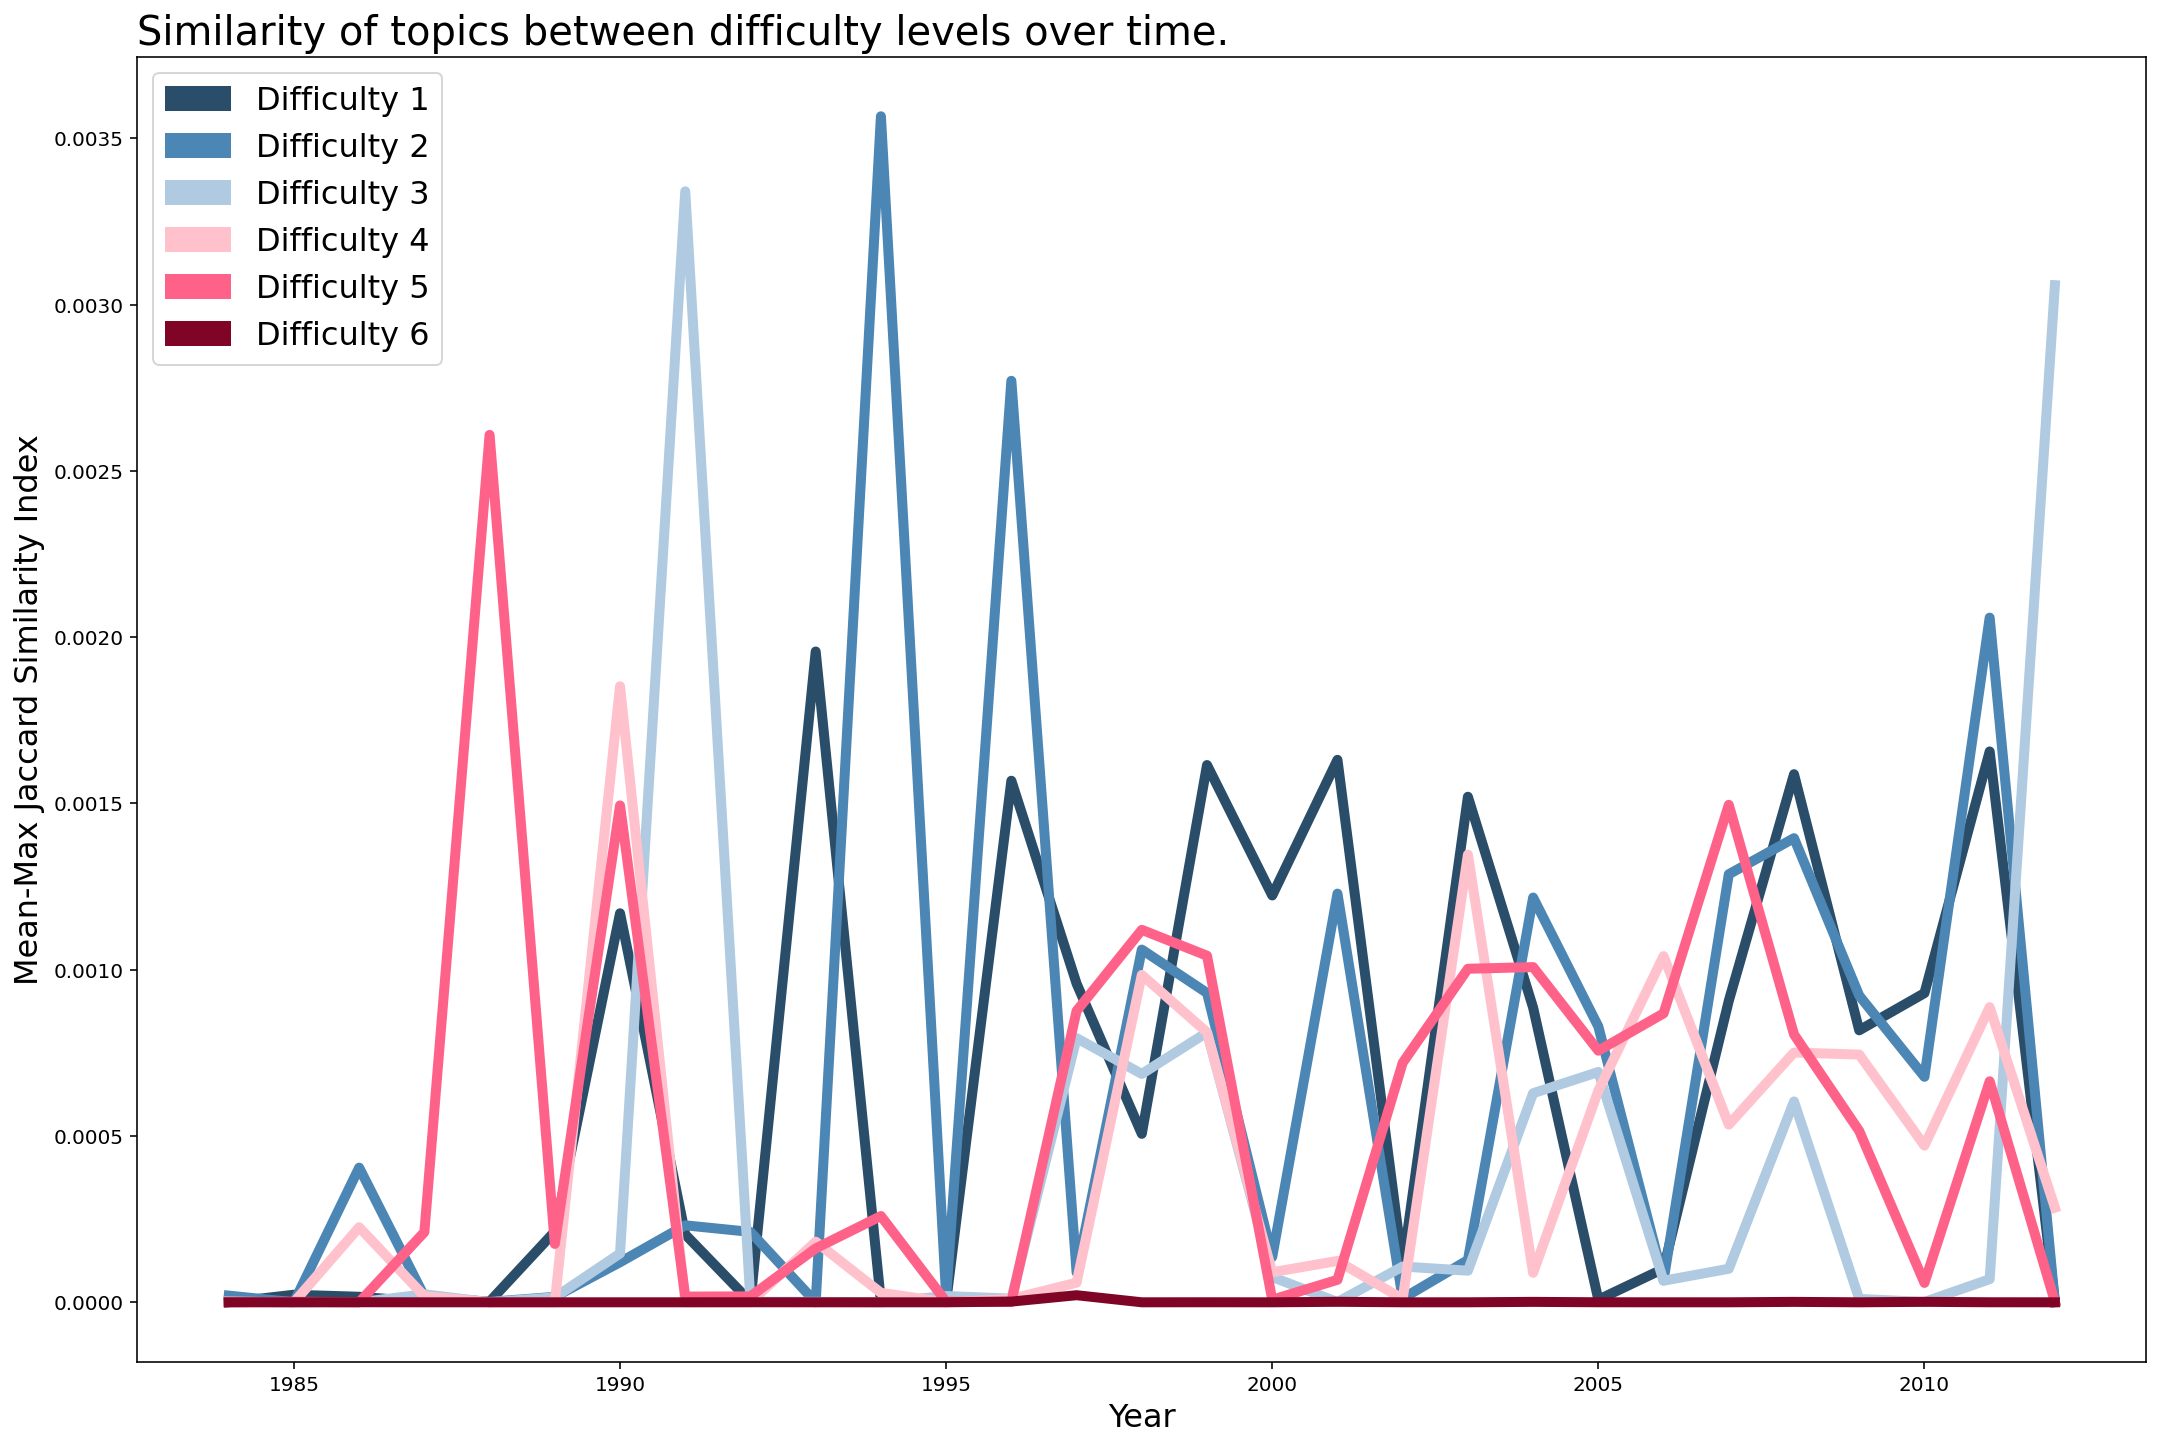

In [57]:
fig, ax = plt.subplots(figsize=(18,12))

colors = {
    1: '#2a4d69',
    2: '#4b86b4',
    3: '#AFCAE1',
    4: '#ffc2cd',
    5: '#ff6289',
    6: '#7f0425'
}

handles = []
for difficulty in range(1,7):
    ax.plot(years, np.exp(np.array(difficulty_similarities[difficulty])), '-', c=colors[difficulty], lw=5)
    handles.append(mpatches.Patch(color=colors[difficulty], label=f'Difficulty {difficulty}'))
    
ax.legend(handles=handles, fontsize=16)
ax.set_title("Similarity of topics between difficulty levels over time.", fontsize=20, loc='left')
ax.set_xlabel('Year', fontsize=16)
ax.set_ylabel('Mean-Max Jaccard Similarity Index', fontsize=16)
plt.show()

The first major observation is that the Difficulty 6 questions have almost no similarity across the lifespan of the entire show, as signified by the dark red line at the bottom. We can also see that Difficulty 3 also has a low level of similarity except for a brief spike in 1991. The rest of the levels seem fairly sporadic. 

I chose to look at raw Jaccard scores for this plot, and we can see from the limits of the y-axis that this plot is actually quite misleading. Jaccard similarity scores are on a range of [0,1], with 1 representing two identical sets. The maximum Jaccard similarity over the entire span is only about 0.0035. I think that this simple fact tells us the most information about the sequences we see, as it tells us that none of the difficulty levels really show a significant similarity across Jeopardy rounds. One conclusion is that, like previously discussed, topics are not linked to difficulty and topics can contain a wide range of difficulty level questions. One other reason we don't have interesting results is that there isnt a lot of data for some years. For instance, there are only 872 questions from the 1985 while there are almost 14,000 questions for 2008. If we had more questions for each year, we may be able to get better results.